In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Configurações de pacotes

In [2]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.set_option('max_colwidth', 180)
sns.set_theme(style="darkgrid")

## Carga dos dados

In [3]:
colunas = ['id_ato', 'data_pub', 'tipo_ato', 'id_seg', 'tipo_seg', 'txt_seg']
df_seg = pd.read_csv('./dados/extracao-segmentos-atos.csv', delimiter='|', names=colunas, quotechar="'")

## Estrutura da fonte de dados

In [4]:
df_seg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206488 entries, 0 to 206487
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id_ato    206488 non-null  int64 
 1   data_pub  206488 non-null  object
 2   tipo_ato  206488 non-null  object
 3   id_seg    206488 non-null  int64 
 4   tipo_seg  206488 non-null  object
 5   txt_seg   204588 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.5+ MB


## Valores ausentes

In [5]:
print('Valores ausentes em {:5d} segmentos'.format(df_seg['txt_seg'].isna().sum()))

Valores ausentes em  1900 segmentos


In [6]:
df_seg[df_seg['txt_seg'].isna()].groupby('tipo_seg').count()['id_seg'].sort_values(ascending=False)

tipo_seg
Anexo               1778
Não Identificado      95
Fecho                 21
Ementa                 2
Artigo                 2
Título                 1
Alínea                 1
Name: id_seg, dtype: int64

#### Notas:
* 206.488 segmentos
* Valores ausentes em 1.900 segmentos, 1.778 (93,57% em segmentos do tipo anexo)
* txt_seg contém o texto dos segmentos a serem analisados
* tipo_seg é a variável alvo (classes)
* Demais atributos podem ser úteis para a análise exploratória

## Tratamento dos segmentos do tipo ANEXO

In [7]:
seg_tipo_anexo = df_seg[df_seg['tipo_seg']=='Anexo']['id_seg'].count()
print(f'Segmentos do tipo anexo: {seg_tipo_anexo}')

Segmentos do tipo anexo: 7549


In [8]:
df_seg[df_seg['tipo_seg']=='Anexo']['txt_seg'].unique()

array([nan, 'Novo segmento', 'Anexo III.pdf', 'a', '&nbsp;', '.', ' ',
       'tabela.html', 'PORT 112-2018.html', 'A', 'Anexo Único.pdf',
       'anexo.html', 'Anexo .html', 'ANEXO II', ',.', ',', 'RELATÓRIO',
       '.a', 'Anexo &Uacute;nico', 'a ', 'to',
       'Assunto: Imposto sobre a Renda de Pessoa Jurídica - IRPJ', '. ',
       'Anexo I .pdf', 'Anexo II .pdf',
       'Assunto: Classificação de Mercadorias',
       'LUIZ HENRIQUE DOMINGUES<br /> Presidente da 4&ordf; Turma',
       'MARCO ANT&Ocirc;NIO RODRIGUES CASADO<br /> Presidente da 5&ordf; Turma',
       'CARLOS HUMBERTO STECKEL<br /> Presidente da 2&ordf; Turma',
       'DANIELLE CARVALHO DE LACERDA<br /> Presidente da 3&ordf; Turma',
       '..', 'Anexo único .html', 'Art. 1&ordm;', 'Art. 1&deg;',
       'Anexo  .html', 'tab1', 'Art 1&ordm;', 'a&nbsp;', '&nbsp;.',
       '\xa0', '\xa0.', 'Anexo I', 'N', 'Anexo II', 'Anexo III',
       'art. 2&ordm;', 'art. 3&ordm;', 'art. 1º', 'anexo &uacute;nico.',
       'art. 1&ordm;

### Notas:
* Os textos dos segmentos do tipo Anexo não possuem relação com o conteúdo do anexo. Como o anexo é armazenado como um arquivo binário, os textos dos segmentos não possuem valor para a classificação do segmento. 
* Por conta dessa característica específica, o tipo de segmento Anexo não será considerado no escopo da classificação. 

In [9]:
# Exclusão dos segmentos do tipo Anexo
df_seg = df_seg[df_seg['tipo_seg']!='Anexo']
seg_sem_anexos = df_seg['id_seg'].count()
print(f'Quantidade segmentos após a exclusão do tipo Anexo: {seg_sem_anexos}')

Quantidade segmentos após a exclusão do tipo Anexo: 198939


In [10]:
# Exclusão dos segmentos com valores ausentes
perc_ausentes = (df_seg['txt_seg'].isna().sum() / df_seg['id_seg'].count()) * 100
print(f'Valores ausentes restantes {perc_ausentes.round(2)}%')
df_seg = df_seg[df_seg['txt_seg'].notna()]
seg_restantes = df_seg['id_seg'].count()
print(f'Quantidade segmentos após a exclusão dos valores ausentes: {seg_restantes}')

Valores ausentes restantes 0.06%
Quantidade segmentos após a exclusão dos valores ausentes: 198817


## Análise da quantidade de atos por tipo de ato

In [11]:
qtd_ato_por_tipo_ato = df_seg[['tipo_ato', 'id_ato']].groupby('tipo_ato')['id_ato'].nunique()
df_qtd_ato_por_tipo_ato = pd.DataFrame(qtd_ato_por_tipo_ato)
df_qtd_ato_por_tipo_ato.columns = ['qtd_ato']
df_qtd_ato_por_tipo_ato.reset_index(inplace=True)
df_qtd_ato_por_tipo_ato.sort_values(by='qtd_ato', ascending=False, inplace=True)

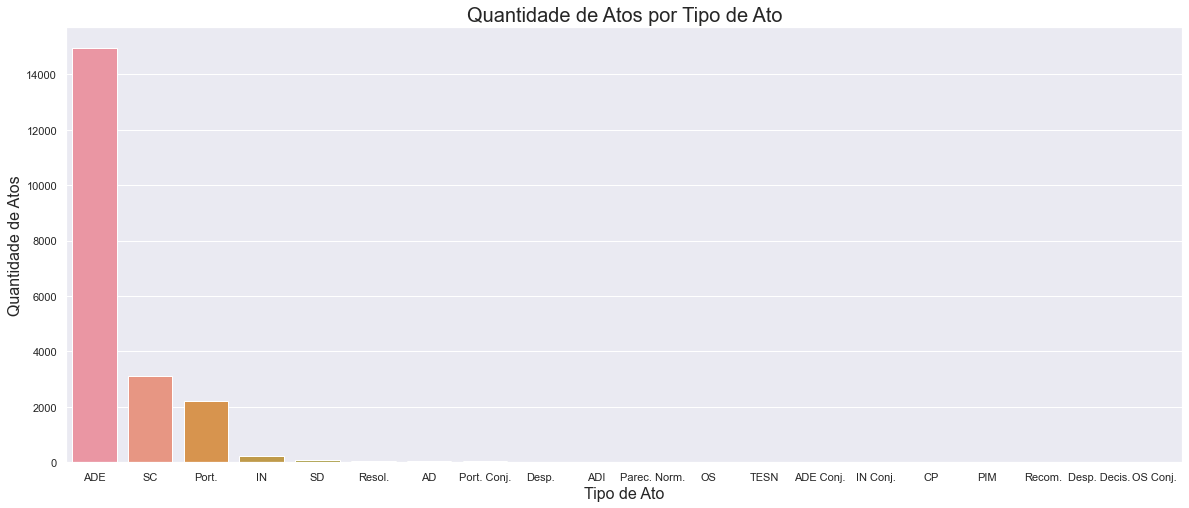

In [12]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='tipo_ato', y='qtd_ato', data=df_qtd_ato_por_tipo_ato)
ax.set_title('Quantidade de Atos por Tipo de Ato', fontsize=20)
ax.set_ylabel('Quantidade de Atos', fontsize=16)
ax.set_xlabel('Tipo de Ato', fontsize=16)
plt.show()

In [13]:
qtd_total_ato = df_qtd_ato_por_tipo_ato['qtd_ato'].sum()

qtd_ato_ade = df_qtd_ato_por_tipo_ato[df_qtd_ato_por_tipo_ato['tipo_ato'] == 'ADE']['qtd_ato'].iloc[0]
qtd_ato_sc = df_qtd_ato_por_tipo_ato[df_qtd_ato_por_tipo_ato['tipo_ato'] == 'SC']['qtd_ato'].iloc[0]
qtd_ato_port = df_qtd_ato_por_tipo_ato[df_qtd_ato_por_tipo_ato['tipo_ato'] == 'Port.']['qtd_ato'].iloc[0]
qtd_ato_menos_frequentes = df_qtd_ato_por_tipo_ato[df_qtd_ato_por_tipo_ato['qtd_ato']<1000]['qtd_ato'].sum()

perc_ato_ade = (qtd_ato_ade*100)/qtd_total_ato
perc_ato_sc = (qtd_ato_sc*100)/qtd_total_ato
perc_ato_port = (qtd_ato_port*100)/qtd_total_ato
perc_ato_menos_frequentes = (qtd_ato_menos_frequentes*100)/qtd_total_ato

In [14]:
dict_qtd_ato_por_tipo_ato = {
    'ADE': [qtd_ato_ade, perc_ato_ade],
    'SC': [qtd_ato_sc, perc_ato_sc],
    'PORT': [qtd_ato_port, perc_ato_port],
    'OUTROS': [qtd_ato_menos_frequentes, perc_ato_menos_frequentes]
}

df_qtd_ato_por_tipo_ato = pd.DataFrame(dict_qtd_ato_por_tipo_ato)
df_qtd_ato_por_tipo_ato = df_qtd_ato_por_tipo_ato.T
df_qtd_ato_por_tipo_ato.reset_index(inplace=True)
df_qtd_ato_por_tipo_ato.columns = ['tipo_ato','qtd_ato','perc_ato']
print(df_qtd_ato_por_tipo_ato)

  tipo_ato  qtd_ato   perc_ato
0      ADE  14948.0  71.792901
1       SC   3119.0  14.980068
2     PORT   2206.0  10.595072
3   OUTROS    548.0   2.631958


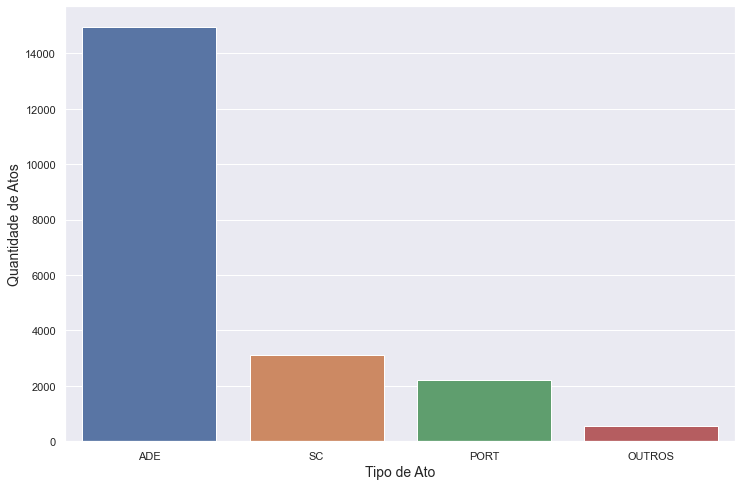

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='tipo_ato', y='qtd_ato', data=df_qtd_ato_por_tipo_ato)
#ax.set_title('Quantidade de Atos por Tipo de Ato', fontsize=20)
ax.set_ylabel('Quantidade de Atos', fontsize=14)
ax.set_xlabel('Tipo de Ato', fontsize=14)
ax.set
plt.show()

### Análise da quantidade de segmentos por tipo de segmento

In [16]:
qtd_seg_por_tipo_seg = df_seg[['id_seg', 'tipo_seg']].groupby('tipo_seg').count().sort_values("id_seg", ascending=False)
qtd_seg_por_tipo_seg.columns = ['qtd_seg']
qtd_seg_por_tipo_seg.reset_index(inplace=True)

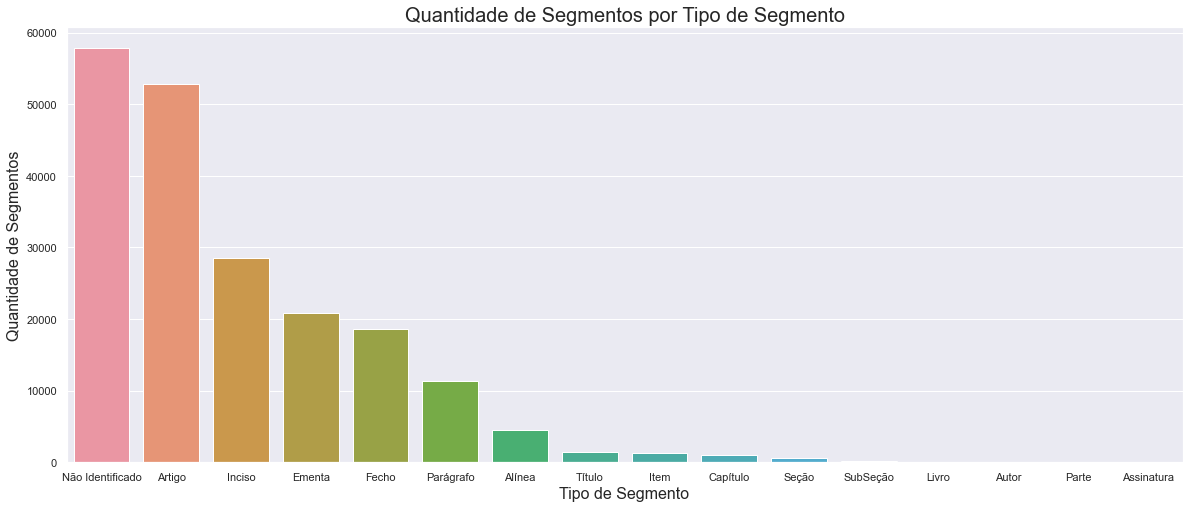

In [17]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg', data=qtd_seg_por_tipo_seg)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

In [18]:
qtd_seg_por_tipo_seg

,tipo_seg,qtd_seg
0,Não Identificado,57846
1,Artigo,52806
2,Inciso,28479
3,Ementa,20822
4,Fecho,18550
5,Parágrafo,11404
6,Alínea,4474
7,Título,1423
8,Item,1218
9,Capítulo,950


In [44]:
#qtd_seg_por_tipo_seg[qtd_seg_por_tipo_seg['qtd_seg'] > 600]
qtd_seg_por_tipo_seg[qtd_seg_por_tipo_seg['qtd_seg'] < 600]

,tipo_seg,qtd_seg
10,Seção,582
11,SubSeção,209
12,Livro,39
13,Autor,7
14,Parte,6
15,Assinatura,2


In [ ]:
qtd_total_seg = qtd_seg_por_tipo_seg['qtd_seg'].sum()




qtd_ato_ni = qtd_seg_por_tipo_seg[qtd_seg_por_tipo_seg['tipo_seg'] == 'Não Identificado']['qtd_seg'].iloc[0]
qtd_ato_artigo = qtd_seg_por_tipo_seg[qtd_seg_por_tipo_seg['tipo_seg'] == 'SC']['qtd_seg'].iloc[0]
qtd_ato_port = qtd_seg_por_tipo_seg[qtd_seg_por_tipo_seg['tipo_seg'] == 'Port.']['qtd_seg'].iloc[0]
qtd_ato_menos_frequentes = df_qtd_ato_por_tipo_ato[df_qtd_ato_por_tipo_ato['qtd_seg']<1000]['qtd_seg'].sum()

perc_ato_ade = (qtd_ato_ade*100)/qtd_total_ato
perc_ato_sc = (qtd_ato_sc*100)/qtd_total_ato
perc_ato_port = (qtd_ato_port*100)/qtd_total_ato
perc_ato_menos_frequentes = (qtd_ato_menos_frequentes*100)/qtd_total_ato

#### Notas:
* 17 classes
* Forte desbalanceamento entre as classes
* Algumas classes com pouca representatividade (poucas instâncias)
* Segmentos não identificados são maioria:
  * Omissão da classificação manual (segmento deveria ser de outra classe)?
  * A classe está sendo usada para alguma situação específica?
  * Segmentos que não precisam estar classificados em nenhuma outra classe?

## Análise considerando somente os atos do tipo ADE

### Carga dos dados considerando uma nova extração (somente atos ADE)

In [19]:
df_seg_ade = df_seg[df_seg['tipo_ato']=='ADE'] 

In [20]:
df_seg_ade.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110739 entries, 277 to 206380
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id_ato    110739 non-null  int64 
 1   data_pub  110739 non-null  object
 2   tipo_ato  110739 non-null  object
 3   id_seg    110739 non-null  int64 
 4   tipo_seg  110739 non-null  object
 5   txt_seg   110739 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.9+ MB


In [21]:
print('Valores ausentes em {:5d} segmentos.'.format(df_seg_ade['txt_seg'].isna().sum()))

Valores ausentes em     0 segmentos.


#### Notas:
* Redução do número de segmentos de 206.488 para 115.040
* Redução do número de atos de 20.821 para 14.948
* Redução dos valores ausentes de 1.900 para 622

### Tratamento de valores ausentes

In [22]:
total_seg_ade = df_seg_ade['id_seg'].count()
qtd_valores_ausentes = df_seg_ade['txt_seg'].isna().sum()
perc_valores_ausentes = qtd_valores_ausentes / total_seg_ade
print('Percentual de valores ausentes: {:5.2f}%'.format(perc_valores_ausentes*100))

Percentual de valores ausentes:  0.00%


#### Notas:
* Valores ausentes representam somente 0.54% dos valores de segmentos e podem ser excluídos.

In [23]:
# Exclusão de segmentos com valores ausentes
df_seg_ade=df_seg_ade[df_seg_ade['txt_seg'].notna()]

### Análise da quantidade de segmentos por tipo de segmento para atos ADE

In [24]:
qtd_seg_tipo_seg_ade = df_seg_ade[['id_seg', 'tipo_seg']].groupby('tipo_seg').count().sort_values("id_seg", ascending=False)
qtd_seg_tipo_seg_ade.columns = ['qtd_seg']
qtd_seg_tipo_seg_ade.reset_index(inplace=True)

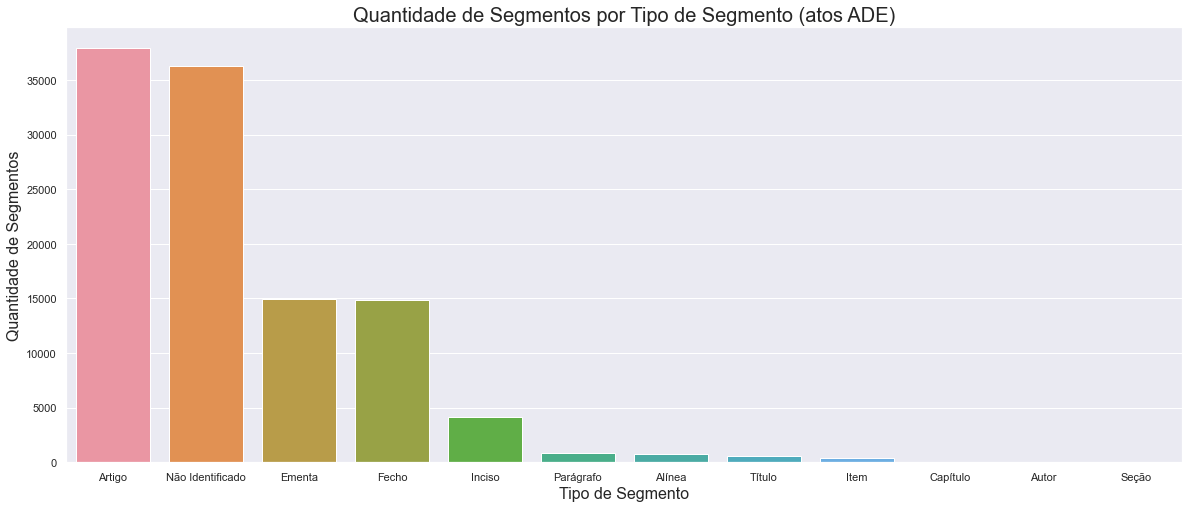

In [25]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg', data=qtd_seg_tipo_seg_ade)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento (atos ADE)', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

In [26]:
qtd_seg_tipo_seg_ade

,tipo_seg,qtd_seg
0,Artigo,37921
1,Não Identificado,36288
2,Ementa,14948
3,Fecho,14853
4,Inciso,4134
5,Parágrafo,861
6,Alínea,780
7,Título,545
8,Item,398
9,Capítulo,5


### Análise da quantidade de atos (ADE) por tipo de segmento

In [27]:
qtd_ato_ade = df_seg_ade[['id_ato', 'tipo_seg']].groupby('tipo_seg')['id_ato'].nunique()
qtd_seg_tipo_seg_ade = qtd_seg_tipo_seg_ade.merge(qtd_ato_ade, how='inner', on='tipo_seg')
qtd_seg_tipo_seg_ade.rename(columns = {'id_ato':'qtd_ato'}, inplace=True)
qtd_seg_tipo_seg_ade

,tipo_seg,qtd_seg,qtd_ato
0,Artigo,37921,12679
1,Não Identificado,36288,14939
2,Ementa,14948,14948
3,Fecho,14853,14629
4,Inciso,4134,752
5,Parágrafo,861,650
6,Alínea,780,144
7,Título,545,512
8,Item,398,163
9,Capítulo,5,1


### Comparando os resultados com todos os tipos de ato e somente com atos ADE

In [28]:
df_seg_comparativo = qtd_seg_por_tipo_seg.merge(qtd_seg_tipo_seg_ade, how='left', on='tipo_seg')
df_seg_comparativo = df_seg_comparativo.rename(columns = {'qtd_seg_x': 'qtd_seg', 'qtd_seg_y':'qtd_seg_ade'})

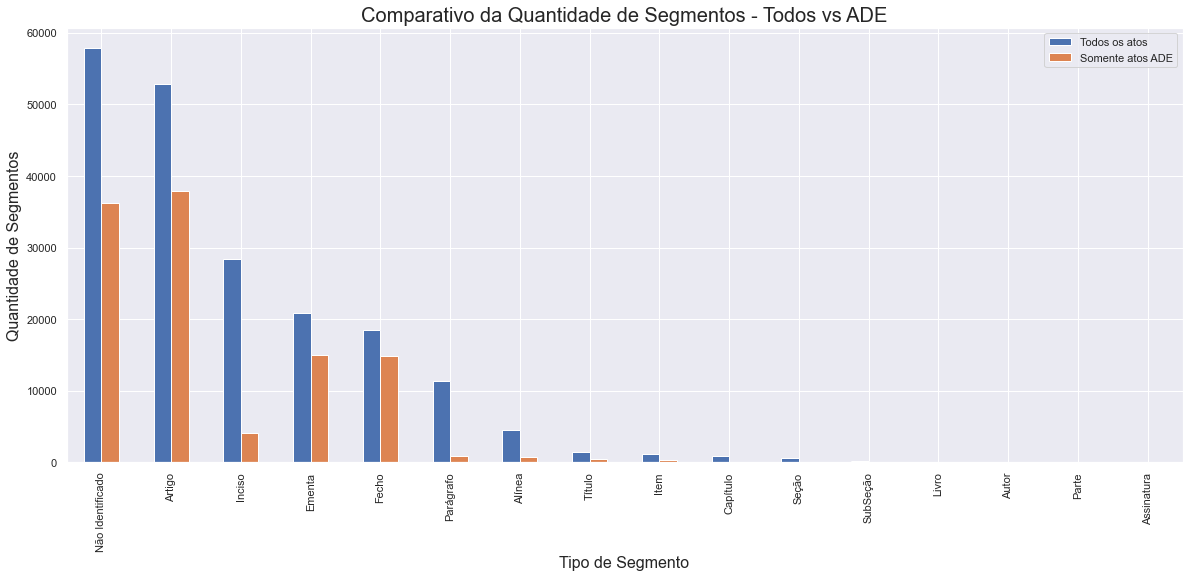

In [29]:
ax = df_seg_comparativo[['tipo_seg', 'qtd_seg', 'qtd_seg_ade']].plot(kind='bar', x='tipo_seg', figsize=(20,8))
ax.set_title('Comparativo da Quantidade de Segmentos - Todos vs ADE', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
ax.legend(['Todos os atos', 'Somente atos ADE'])
plt.show()

In [30]:
df_seg_comparativo

,tipo_seg,qtd_seg,qtd_seg_ade,qtd_ato
0,Não Identificado,57846,36288.0,14939.0
1,Artigo,52806,37921.0,12679.0
2,Inciso,28479,4134.0,752.0
3,Ementa,20822,14948.0,14948.0
4,Fecho,18550,14853.0,14629.0
5,Parágrafo,11404,861.0,650.0
6,Alínea,4474,780.0,144.0
7,Título,1423,545.0,512.0
8,Item,1218,398.0,163.0
9,Capítulo,950,5.0,1.0


#### Notas:
* Segmentos não identificados deixaram de ser majoritários, mas ainda carecem de uma avaliação mais detalhada
* As categorias Assinatura, Parte, Livro e Subseção não possuem segmento para atos ADE
* As categorias Parágrafo, Alínea, Título, Item, Capítuo, Autor e Seção ficaram com representatividade baixa (abaixo de 1%)

### Excluindo classes com pouca (<1%) ou nenhuma representatividade (NaN) em atos ADE

In [31]:
# Nenhuma representatividade
df_seg_comparativo.dropna(inplace=True)
df_seg_comparativo['qtd_seg_ade'] = df_seg_comparativo['qtd_seg_ade'].astype('int')

In [32]:
df_seg_comparativo['perc_seg_ade'] = df_seg_comparativo['qtd_seg_ade']/total_seg_ade

In [33]:
# Pouca representatividade
df_seg_comparativo = df_seg_comparativo[df_seg_comparativo['perc_seg_ade']>=0.01]

In [34]:
df_seg_comparativo = df_seg_comparativo.sort_values(by='qtd_seg_ade', ascending=False)

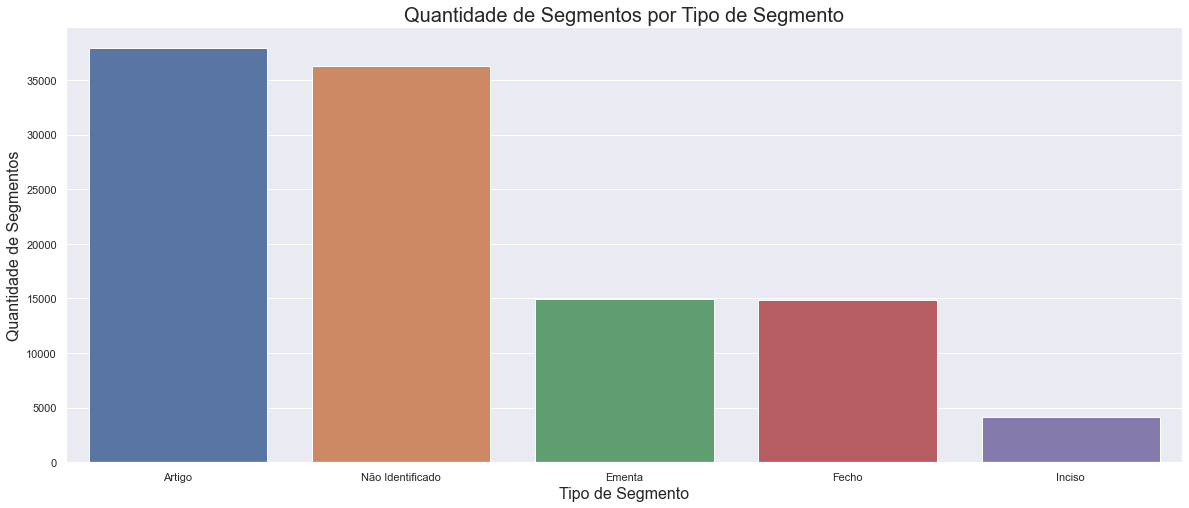

In [35]:
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(x='tipo_seg', y='qtd_seg_ade', data=df_seg_comparativo)
ax.set_title('Quantidade de Segmentos por Tipo de Segmento', fontsize=20)
ax.set_ylabel('Quantidade de Segmentos', fontsize=16)
ax.set_xlabel('Tipo de Segmento', fontsize=16)
plt.show()

In [36]:
df_seg_comparativo

,tipo_seg,qtd_seg,qtd_seg_ade,qtd_ato,perc_seg_ade
1,Artigo,52806,37921,12679.0,0.342436
0,Não Identificado,57846,36288,14939.0,0.327689
3,Ementa,20822,14948,14948.0,0.134984
4,Fecho,18550,14853,14629.0,0.134126
2,Inciso,28479,4134,752.0,0.037331


## Explorando os dados dos diferentes tipos de segmento

### Tipo: ARTIGO

In [37]:
df_seg_ade[df_seg_ade['tipo_seg']=='Artigo'][['id_ato','id_seg','txt_seg']].sample(15)

,id_ato,id_seg,txt_seg
120146,103400,2014858,Art. 2º Este Ato Declaratório Executivo entra em vigor na data de sua publicação no Diário Oficial da União - DOU.
24804,91735,1886712,"Art. 1&ordm; Para fins de informa&ccedil;&atilde;o de compensa&ccedil;&atilde;o do Imposto de Exporta&ccedil;&atilde;o, na Ficha D&eacute;bito, do Programa Pedido de Restitui&c..."
178373,111854,2175598,Art. 2º Este Ato Declaratório Executivo entra em vigor na data de sua publicação no DOU.
200398,114068,2211599,Art. 2º. Estão obrigadas à apuração do lucro real as pessoas jurídicas que usufruam de benefícios fiscais relativos à isenção ou à redução do imposto.
35800,93021,1901775,"Art. 1º Fica excluída do Parcelamento Especial (Paes) de que trata o art. 1º da Lei nº 10.684, de 30 de maio de 2003, de acordo com seu art. 7º, a pessoa jurídica LUIZ VILMAR D..."
166754,110450,2151260,"Art. 1&ordm; - Com fundamento nos &sect; 4&ordm; do artigo 810 do Decreto n&ordm; 6.759/2009 , alterado pelo Decreto n&ordm; 7.213/2010, c/c art. 4&ordm; da Portaria RFB n&ordm..."
144785,106478,2087041,"Art. 1º Habilitada definitivamente no âmbito do Programa Mais Leite Saudável, instituído pelo Decreto nº 8.533, de 30 de setembro de 2015, a pessoa jurídica LATICINIOS MONTE CE..."
186283,112951,2192051,"Art. 1º Reconhecido o direito da pessoa jurídica CELLERA FARMACÊUTICA S.A inscrita no CNPJ sob o nº 33.173.097/0002-74, à utilização do crédito presumido de PIS/Pasep e Cofins ..."
193321,113467,2201677,"Art. 1° HABILITADA a pessoa jurídica USINA DE ENERGIA FOTOVOLTAICA JANAUBA X LTDA. inscrita no CNPJ n°37.381.180/0001-09, para operar no Regime Especial de Incentivos para o De..."
51534,95124,1926953,"Art. 4º. Este Ato entra em vigor na data de sua publicação no Diário Oficial da União, produzindo efeitos a partir de 24 de outubro de 2017."


### Notas:
* Padrão "Art. <número ordinal>" (manter ou remover o ordinal?)
* Caracteres de escape HTML eventualmente aparece no lugar do ordinal (tratar HTML escapes na limpeza)
* Presença de nomes de entidades (empresas, órgãos, pessoas, leis, impostos, etc) - Considerar a utilização de NER

### Tipo: EMENTA

In [38]:
df_seg_ade[df_seg_ade['tipo_seg']=='Ementa'][['id_ato','id_seg','txt_seg']].sample(15)

,id_ato,id_seg,txt_seg
6637,89695,1857271,Exclui pessoa jurídica do Refis.
3568,89285,1847011,"Exclui pessoas físicas e jurídicas do Parcelamento Especial (Paes), de que trata o art. 1º da Lei nº 10.684, de 30 de maio de 2003."
35365,92992,1901276,Anular inscrições no Cadastro Nacional de Pessoa Jurídica.
148888,107249,2098601,"Declara a habilitação definitiva no Programa Mais Leite Saudável, instituído pelo Decreto nº 8.533, de 30 de setembro de 2015."
59533,96126,1936606,Concede co-habilitação ao Regime Especial de Incentivos para o Desenvolvimento da Infraestrutura (Reidi).
196799,113791,2206657,Concede regime especial de substituição tributária do Imposto sobre Produtos Industrializados (IPI).
58757,96011,1935775,Habilitação ao Regime Especial de Incentivos para o Desenvolvimento da Infraestrutura (REIDI).
165196,110222,2147707,&quot;Declara nula a inscri&ccedil;&atilde;o que menciona no Cadastro Nacional da Pessoa Jur&iacute;dica - CNPJ.&quot;
46859,94509,1920150,"Coabilita a pessoa jurídica que menciona, ao Regime Especial de Incentivos para o Desenvolvimento da Infraestrutura (REIDI)."
114899,102836,2008400,Prorroga o Alfandegamento do Recinto que menciona


### Notas:
* Padrão "verbo" ou "substantivo" indicando ação (possível benefício do uso de POS-TAGGING)
* Aspas desnecessárias no início e no final de alguns segmentos (remover na limpeza)
* Caracteres de escape HTML (tratar HTML escapes na limpeza)
* Presença de nomes de entidades (empresas, órgãos, pessoas, leis, impostos, etc) - Considerar a utilização de NER 

### Tipo: FECHO

In [39]:
df_seg_ade[df_seg_ade['tipo_seg']=='Fecho'][['id_ato','id_seg','txt_seg']].sample(15)

,id_ato,id_seg,txt_seg
74230,97823,1955241,KARINE PEREIRA PESSOA PENNA
66077,96819,1944766,FABIO NEI TELES
159860,108985,2125984,MURILO AMARAL DE OLIVEIRA E SILVA
184408,112665,2188441,VITOR SILVANY RAMOS&nbsp;
95999,100479,1984870,PATRICIA MARIA FÉRES DO SOCORRO SANDOR
124100,103939,2020697,JORDÃO NÓBRIGA DA SILVA JUNIOR
132258,104625,2065989,MANOEL ALENCAR DOS SANTOS
130516,104326,2058385,GIOVANNI CHRISTIAN NUNES CAMPOS
167543,110567,2153030,FILIPE ARAÚJO FLORÊNCIO
166853,110462,2151360,RUY AFONSO LOPES SALDANHA


In [40]:
# Segmentos preenchido com caractere ponto sozinho
regex = '^(\.)'
segs = df_seg_ade[df_seg_ade['tipo_seg']=='Fecho']
segs[segs['txt_seg'].str.contains(regex)]['id_seg'].count()

/home/91872936504/devx/saan/.env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


372

### Notas:
* Formado por nomes próprios em caixa alta
* Exceções:
  * 372 segmentos com caractere ponto sozinho (investigar)
  * Caracteres de escape HTML (tratar HTML escapes na limpeza)

### Tipo: INCISO

In [41]:
df_seg_ade[df_seg_ade['tipo_seg']=='Inciso'][['id_ato','txt_seg']].sample(15)

,id_ato,txt_seg
89848,99677,V – Condição onerosa atendida: Modernização Total de empreendimento na área de atuação da Superintendência do Desenvolvimento do Nordeste – SUDENE;
89849,99677,"VI – Setor prioritário considerado: Indústria de Transformação – Bebidas, Decreto 4.213, art. 2º, inciso VI, alínea i;"
89353,99589,VIII – Capacidade Instalada atual (anual):
137863,105344,XII - Prazo total de fruição: 10 anos;
137854,105344,"III - Endereço da Unidade Produtora: AVENIDA ENGENHEIRO EMILIANO MACIEIRA, 1, KM 18, PEDRINHAS, SÃO LUIS-MA - CEP: 65095-603."
105149,101613,VII - Descrição da Atividade: Abate de Aves;
101365,101091,IV - Percentual de redução do Imposto de Renda das Pessoas Jurídicas e adicionais não restituíveis: 75% (setenta e cinco por cento);
74376,97881,"I – a restituição de capital aos sócios, em caso de redução do capital social, até o montante do aumento com incorporação da reserva; e"
69314,97205,II – CNPJ do estabelecimento incentivado: nº 07.861.712/0002-25;
109527,102238,"V - Condição onerosa atendida: Modernização total de empreendimento na área de atuação da Superintendência do Desenvolvimento do Nordeste (Sudene), considerada implantação de n..."


### Notas:
* Padrão "número em romano - ..."
* Presença de nomes de entidades (empresas, órgãos, pessoas, leis, impostos, etc) - Considerar a utilização de NER 

### Tipo: ANEXO

In [42]:
df_seg_ade[df_seg_ade['tipo_seg']=='Anexo'][['id_ato','txt_seg']].sample(15)

ValueError: a must be greater than 0 unless no samples are taken

### Tipo: NÃO IDENTIFICADO

In [ ]:
segs = df_seg_ade[df_seg_ade['tipo_seg']=='Não Identificado'][['id_seg','txt_seg']]
#segs.sample(15)
segs.count()

id_seg     36288
txt_seg    36288
dtype: int64

In [ ]:
# Padrão com 4 ou mais caracteres de ponto em qualquer trecho do segmento
regex = '(\.{4,})'
segs[segs['txt_seg'].str.contains(regex)].count()['id_seg']

/home/91872936504/devx/saan/.env/lib/python3.6/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


71

In [ ]:
# Padrão iniciando com qualquer quantidade de espaços seguidos de 'Art' e depois ponto ou espaço
regex = '^(\s{0,})Art[\s\.]'
segs[segs['txt_seg'].str.contains(regex)].count()['id_seg']

1414

### Notas:
* Encontrados 71 segmentos formados por grande quantidade de pontos. Como a quantidade foi muito pequena, se comparada ao total de segmentos dessa classe (36.288), esses segmentos serão mantidos (inicialmente como segmentos válidos para a classe).
* Encontrados 1.414 segmentos (3,9% do total) com padrões de texto parecidos com artigos. Foi realizada uma inspeção de alguns atos desse conjunto e a hipótese mais provável é de omissão de classificação. Esses segmentos serão reclassificados durante a etapa de limpeza.
* Não foram encontrados outros padrões e foi assumido que os demais 34.874 segmentos (96,1%) serão considerados como não identificados (válidos para classe em questão). 


### Comparando a quantidade final de segmentos

In [ ]:
tipo_seg_mantidos = ['Não Identificado', 'Artigo', 'Ementa', 'Fecho', 'Inciso']
df_seg_ade_mantidos = df_seg_ade[df_seg_ade['tipo_seg'].isin(tipo_seg_mantidos)]
perc_seg_mantidos = df_seg_ade_mantidos['id_seg'].count() / df_seg_ade['id_seg'].count()
print('Total de segmentos em atos ADE: {:5d}'.format(df_seg_ade['id_seg'].count()))
print('Total de segmentos mantidos (após o tratamento) em atos ADE: {:5d}'.format(df_seg_ade_mantidos['id_seg'].count()))
print('Percentual de segmentos mantidos (após o tratamento) em atos ADE: {:5.2f}%'.format(perc_seg_mantidos*100))
print('Valores ausentes nos segmentos mantidos: {:5d}'.format(df_seg_ade_mantidos['txt_seg'].isna().sum()))

Total de segmentos em atos ADE: 114418
Total de segmentos mantidos (após o tratamento) em atos ADE: 108144
Percentual de segmentos mantidos (após o tratamento) em atos ADE: 94.52%
Valores ausentes nos segmentos mantidos:     0


## Conclusões
* Sobre a redução do escopo de dados para os atos do tipo ADE:
  * Permitiu a diminuição do número de tipos de segmentos a serem considerados no treinamento do modelo de classificação (de 17 para 6 tipos);
  * As perdas para o modelo tendem a ser mínimas porque foram removidas somente tipos de segmento sem representatividade ou com representatividade abaixo de 1%;
  * Somados os segmentos dos tipos removidas representam menos de 6% de todos os segmentos em atos ADE (94.52% dos segmentos foram mantidos).
* O escopo de dados permanece significativo já que os atos ADE representam 71.79% do total de atos.
* Sobre os segmentos do tipo Não Identificado:
  * 1.414 segmentos não foram classificados manualmente (assumindo falha humana por omissão na classificação manual) e serão reclassificados como Artigo, devido ao padrão encontrado nos textos desses segmentos.
  * Os demais segmentos permanecerão pertencendo ao tipo Não Identificado.
* Foram encontrados caracteres de escape HTML em segmentos de alguns tipos. O tratamento desses caracteres será considerado na etapa de limpeza de dados.
* O tipo Anexo será desconsiderado por não se tratar de conteúdo textual válido.
* Os 5 tipos restantes estão desbalanceados e um tratamento específico será necessário na etapa de pre-processamento.
* Foram encontrados valores ausentes nos segmentos, mas representavam somente 0.54% dos valores de segmentos e foram excluídos.
